In [1]:
from typing import Dict, Tuple, List, Any
from skimage import io
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from keras.callbacks import History
from tensorflow.keras import models, optimizers, losses, activations, callbacks, initializers, regularizers
from tensorflow.keras.layers import *
import tensorflow.keras.backend as backend
import tensorflow as tf

# Loading Data
def load_data_2(data_dir: str) -> Tuple[Dict[str, Dict[int, np.ndarray]], np.ndarray]:  # Tuple[np.ndarray, np.ndarray]
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    images_for_dict = []
    label_2_images = {}
    directory_counter = 0
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir)
                      if f.endswith(".jpg")]
        file_2_image = {}
        file_counter = 1
        for f in file_names:
            image = io.imread(f)
            # file_2_image[os.path.basename(f)] = image
            file_2_image[file_counter] = image
            images.append(image)
            images_for_dict.append(image)
            labels.append(directory_counter)
            file_counter += 1
        # label_2_images[directory_counter] = np.array(images_for_dict)
        # label_2_images[d] = np.array(images_for_dict)
        label_2_images[d] = file_2_image
        images_for_dict = []
        directory_counter += 1
    return label_2_images, np.array(labels)

In [2]:
def prepare_x_y_according_to_description(label_2_images: Dict[str, Dict[int, np.ndarray]], file: str) -> Tuple[List[np.ndarray], np.ndarray]:
    samples_1_test = list()
    samples_2_test = list()
    labels_test = list()
    with open(file, 'r+') as f:
        train_lines = f.readlines()
        num_of_samples = int(train_lines[0].strip())
        for index in range(1, num_of_samples + 1, 1):
            line = train_lines[index]
            words = line.split()
            image1 = label_2_images[words[0]][int(words[1])]
            image2 = label_2_images[words[0]][int(words[2])]
            samples_1_test.append(image1.reshape(250**2) / 255)  
            samples_2_test.append(image2.reshape(250**2) / 255)
            labels_test.append(1)
        for index in range(num_of_samples + 1, 2 * num_of_samples + 1, 1):
            line = train_lines[index]
            words = line.split()
            image1 = label_2_images[words[0]][int(words[1])]
            image2 = label_2_images[words[2]][int(words[3])]
            samples_1_test.append(image1.reshape(250**2) / 255)  
            samples_2_test.append(image2.reshape(250**2) / 255)
            labels_test.append(0)
    return [np.array(samples_1_test), np.array(samples_2_test)], np.array(labels_test)


In [3]:
# class OneShotModel(object):

#     def __init__(self):
#         self.__dim = 250
#         input_shape = (self.__dim ** 2,)
#         convolution_shape = (self.__dim, self.__dim, 1)
#         strides = 1
#         seq_conv_model = [

#             Reshape(input_shape=input_shape, target_shape=convolution_shape),
#             Conv2D(32, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
#             Conv2D(32, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
#             BatchNormalization(),
#             MaxPooling2D(pool_size=(2, 2), strides=2),
#             Conv2D(64, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
#             Conv2D(64, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
#             BatchNormalization(),
#             MaxPooling2D(pool_size=(2, 2), strides=2),
#             Conv2D(128, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
#             Conv2D(128, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
#             BatchNormalization(),
#             MaxPooling2D(pool_size=(2, 2), strides=2),
#             Conv2D(256, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.RandomNormal(stddev=0.01)),
#             Conv2D(256, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.RandomNormal(stddev=0.01)),
#             BatchNormalization(),
#             MaxPooling2D(pool_size=(2, 2), strides=2),
#             Flatten(),
#             Dense(1024, activation=activations.relu, kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.01)),
#             # BatchNormalization(),
#             Dense(1024, activation=activations.sigmoid, kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.01))
#             # Dense(1024, activation=activations.sigmoid, kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.01))
#         ]


#         seq_model = tf.keras.Sequential(seq_conv_model)

#         input_x1 = Input(shape=input_shape)
#         input_x2 = Input(shape=input_shape)

#         output_x1 = seq_model(input_x1)
#         output_x2 = seq_model(input_x2)

#         distance_euclid = Lambda(lambda tensors: backend.abs(tensors[0] - tensors[1]))([output_x1, output_x2])
#         outputs = Dense(1, activation=activations.sigmoid)(distance_euclid)
#         self.__model = models.Model([input_x1, input_x2], outputs)

#         self.__model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])
#         print(self.__model.summary())

#     def fit(self, x, y, hyper_parameters):
#         # This callback will stop the training when there is no improvement in
#         # the validation loss for three consecutive epochs.
#         callback = callbacks.EarlyStopping(monitor='loss', patience=3)
#         callback2 = callbacks.LearningRateScheduler(self._lr_scheduler)
#         # callback = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
#         history = self.__model.fit(x, y, batch_size=hyper_parameters['batch_size'], epochs=hyper_parameters['epochs'],
#                                    callbacks=[callback, callback2], validation_split=hyper_parameters['validation_split'], verbose=2)
#                                    #validation_data=hyper_parameters['val_data'])

#         self.__model.summary()
#         return history

#     def predict(self, x):
#         predictions = self.__model.predict(x)
#         return predictions

#     def _lr_scheduler(self, epoch, lr):
#         return 0.9 * lr

#     def evaluate(self, x, y):
#         predictions = self.__model.evaluate(x, y)
#         return predictions

#     # to get a picture of loss progress.
#     def plot_metric(self, history: History, metric: str = 'loss') -> None:
#         import matplotlib.pyplot as plt
#         train_metrics = history.history[metric]
#         val_metrics = history.history['val_'+metric]
#         epochs = range(1, len(train_metrics) + 1)
#         plt.plot(epochs, train_metrics)
#         plt.plot(epochs, val_metrics)
#         plt.title('Training and validation '+ metric)
#         plt.xlabel("Epochs")
#         plt.ylabel(metric)
#         plt.legend(["train_"+metric, 'val_'+metric])
#         plt.show()


In [13]:



class OneShotModel(object):

    def __init__(self):
        self.__dim = 250
        input_shape = (self.__dim ** 2,)
        convolution_shape = (self.__dim, self.__dim, 1)
        seq_conv_model = [

            Reshape(input_shape=input_shape, target_shape=convolution_shape),
            Conv2D(32, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
            Conv2D(32, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),
            Conv2D(64, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
            Conv2D(64, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),
            Conv2D(128, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
            Conv2D(128, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.glorot_normal),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),
            Conv2D(256, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.RandomNormal(stddev=0.01)),
            Conv2D(256, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.RandomNormal(stddev=0.01)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),
            Conv2D(512, kernel_size=(3, 3), strides=1, activation=activations.relu, padding="same", kernel_initializer=initializers.RandomNormal(stddev=0.01)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),
            Flatten(),
            Dense(1024, activation=activations.relu, kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.01)),
            # BatchNormalization(),
            Dense(1024, activation=activations.sigmoid, kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.01))
            # Dense(1024, activation=activations.sigmoid, kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.01))
        ]


        seq_model = tf.keras.Sequential(seq_conv_model)

        input_x1 = Input(shape=input_shape)
        input_x2 = Input(shape=input_shape)

        model_x1 = seq_model(input_x1)
        model_x2 = seq_model(input_x2)

        model_distance_l2 = Lambda(lambda tensors: backend.abs(tensors[0] - tensors[1]))([model_x1, model_x2])
        final_output = Dense(1, activation=activations.sigmoid)(model_distance_l2)
        self.__model = models.Model([input_x1, input_x2], final_output)

        self.__model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])
        print(self.__model.summary())

    def fit(self, x, y, hyper_parameters):
        # This callback will stop the training when there is no improvement in
        # the validation loss for three consecutive epochs.
        callback = callbacks.EarlyStopping(monitor='loss', patience=3)
        callback2 = callbacks.LearningRateScheduler(self._lr_scheduler)
        # callback = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
        history = self.__model.fit(x, y, batch_size=hyper_parameters['batch_size'], epochs=hyper_parameters['epochs'],
                                   callbacks=[callback, callback2], verbose=2, validation_data=hyper_parameters['val_data'])
                                   # callbacks=[callback, callback2], validation_split=hyper_parameters['validation_split'], verbose=2, validation_data=hyper_parameters['val_data'])
                                   #validation_data=hyper_parameters['val_data'])

        self.__model.summary()
        return history

    def predict(self, x):
        predictions = self.__model.predict(x)
        return predictions

    def _lr_scheduler(self, epoch, lr):
        return 0.95 * lr

    def evaluate(self, x, y):
        predictions = self.__model.evaluate(x, y)
        return predictions

    # to get a picture of loss progress.
    def plot_metric(self, history: History, metric: str = 'loss') -> None:
        import matplotlib.pyplot as plt
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])
        plt.show()



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

import zipfile
x_train, y_train = None, None

with zipfile.ZipFile('/content/drive/MyDrive/DL/Assignment_1/Data.zip',"r") as zip_ref:
    zip_ref.extractall("temp_dir")
    all_label_2_images, labels = load_data_2("temp_dir/Data")
    x_train, y_train = prepare_x_y_according_to_description(all_label_2_images, '/content/drive/MyDrive/DL/Assignment_1/pairsDevTrain.txt') 
    x_test, y_test = prepare_x_y_according_to_description(all_label_2_images, '/content/drive/MyDrive/DL/Assignment_1/pairsDevTest.txt') 

Num GPUs Available:  1
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 62500)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 62500)]      0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         29096544    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1024)         0           sequ

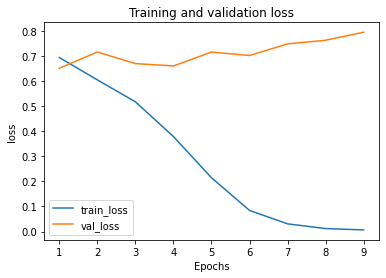

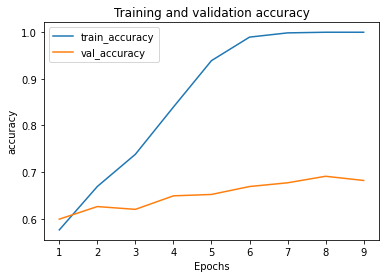

32/32 [==============================] - 4s 112ms/step - loss: 0.7940 - accuracy: 0.6820


In [14]:

import tensorflow as tf
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)
# train_folder = '/content/drive/MyDrive/Data/'
# all_label_2_images, labels = load_data_2(train_folder)
# x_train, y_train = prepare_x_y_according_to_description(all_label_2_images, '/content/drive/MyDrive/DL/Assignment_1/pairsDevTrain.txt')

model = OneShotModel()
parameters = {
    'batch_size' : 8 ,
    'validation_split' : 0.2 ,
    'epochs' : 9 ,
    'val_data' : (x_test, y_test)
}
h = model.fit(x_train, y_train, parameters)
model.plot_metric(h)
model.plot_metric(h, metric="accuracy")
score = model.evaluate(x_test, y_test)

1/1 [==============================] - 1s 863ms/step - loss: 0.1456 - accuracy: 1.0000


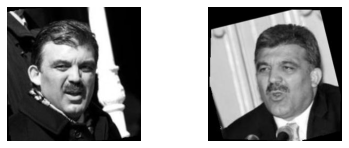

In [8]:
# same people /  correct
sample_1 = np.array([x_test[0][0]])
sample_2 = np.array([x_test[1][0]])
y_sample =  np.array([1])
same_test_images = [sample_1, sample_2]
result = model.evaluate(same_test_images, y_sample)
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.axis('off')
    plt.imshow(x_test[i][0].reshape((250, 250)), cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
# Show the plot
plt.show()

1/1 [==============================] - 0s 24ms/step - loss: 0.5578 - accuracy: 1.0000


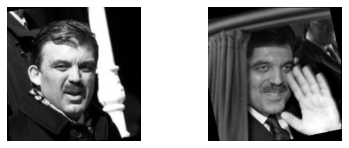

'\nthe model got wrong here might be because some parts of the face is covered with hand and also some part of the head is not seen or in shadow\n'

In [9]:
# same people / incorrect 
sample_1 = np.array([x_test[0][1]])
sample_2 = np.array([x_test[1][1]])
y_sample =  np.array([1])
same_test_images = [sample_1, sample_2]
result = model.evaluate(same_test_images, y_sample)
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.axis('off')
    plt.imshow(x_test[i][1].reshape((250, 250)), cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
# Show the plot
plt.show()

"""
the model got wrong here might be because some parts of the face is covered with hand and also some part of the head is not seen or in shadow
"""


1/1 [==============================] - 0s 25ms/step - loss: 0.4283 - accuracy: 1.0000


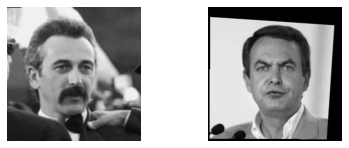

In [10]:
# deferent people /  correct
sample_1 = np.array([x_test[0][502]])
sample_2 = np.array([x_test[1][502]])
y_sample =  np.array([1])
same_test_images = [sample_1, sample_2]
result = model.evaluate(same_test_images, y_sample)
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.axis('off')
    plt.imshow(x_test[i][502].reshape((250, 250)), cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
# Show the plot
plt.show()

1/1 [==============================] - 0s 26ms/step - loss: 9.9361 - accuracy: 0.0000e+00


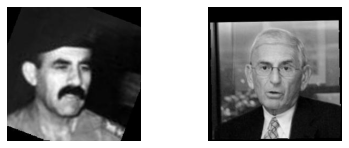

'\nthe model got wrong here - actuall the 2 faces have similarity to my mind :)\n'

In [11]:
# deferent people /  incorrect
sample_1 = np.array([x_test[0][505]])
sample_2 = np.array([x_test[1][505]])
y_sample =  np.array([1])
same_test_images = [sample_1, sample_2]
result = model.evaluate(same_test_images, y_sample)
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.axis('off')
    plt.imshow(x_test[i][505].reshape((250, 250)), cmap="gray")
    plt.subplots_adjust(wspace=0.5)

plt.show()
"""
the model got wrong here - actuall the 2 faces have similarity to my mind :)
"""

In [12]:
# find indexes for in/correct predictions

for i in range(500, 520):
  sample_1 = np.array([x_test[0][i]])
  sample_2 = np.array([x_test[1][i]])
  y_sample =  np.array([1])
  same_test_images = [sample_1, sample_2]
  print("index ",i)
  result = model.evaluate(same_test_images, y_sample)

index  500
1/1 [==============================] - 0s 25ms/step - loss: 3.6510 - accuracy: 0.0000e+00
index  501
1/1 [==============================] - 0s 23ms/step - loss: 0.1605 - accuracy: 1.0000
index  502
1/1 [==============================] - 0s 26ms/step - loss: 0.4283 - accuracy: 1.0000
index  503
1/1 [==============================] - 0s 25ms/step - loss: 0.2120 - accuracy: 1.0000
index  504
1/1 [==============================] - 0s 22ms/step - loss: 2.1339 - accuracy: 0.0000e+00
index  505
1/1 [==============================] - 0s 24ms/step - loss: 9.9361 - accuracy: 0.0000e+00
index  506
1/1 [==============================] - 0s 23ms/step - loss: 0.1693 - accuracy: 1.0000
index  507
1/1 [==============================] - 0s 23ms/step - loss: 0.1136 - accuracy: 1.0000
index  508
1/1 [==============================] - 0s 28ms/step - loss: 0.0561 - accuracy: 1.0000
index  509
1/1 [==============================] - 0s 31ms/step - loss: 0.8709 - accuracy: 0.0000e+00
index  510
1/1